![](figs/se_03.png)
# Workshop Instructions
***
- <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> Follow along by typing the code yourself - this helps with learning!
- <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> Code cells marked as "Exercise" are for you to complete
- <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> Look for hints if you get stuck
- <img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> Compare your solution with the provided answers
- <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> Don't worry if you make mistakes - debugging is part of learning!

In [1]:
%matplotlib widget
import torch
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import utils
from pathlib import Path
import sys

helper_utils = Path.cwd().parent
sys.path.append(str(helper_utils))


checker = utils.core.ExerciseChecker("SE03")
quizzer = utils.core.QuizManager("SE03")

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 1.0.1+1a4f1b1


# 1. PyTorch workflow
***
The previous session we had a look at the basics of neural networks and how to train a single layer perceptron. In this session we will look at the PyTorch framework and how to use it to build and train neural networks.

Most deep learning projects follow a similar workflow. The following figure illustrates the typical workflow of a PyTorch project:

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\pytorch_workflow.png" alt="PyTorch WorkFlow" align="center" style="width: 80%; height: auto; margin: 0 auto;">
</figure>

The workflow consists of the following steps:

| Step | Description |
|------|----------|
| Obtain Data | Collect and preprocess the data for training and testing |
| Prepare Data | Setup data in PyTorch format |
| Pre-process Data | Normalize and augment the data. This may involve data cleaning, normalization, and splitting the data into training, validation, and test sets. |
| Activation Function | Choose an activation function for the model. This may involve selecting a suitable activation function for the model, such as ReLU, sigmoid, or tanh. |
| Model | Define the model architecture. |
| Choose optimiser | Select an optimiser for the model. |
| Choose loss function | Select a loss function for the model. |
| Create training loop | Define the training steps, including forward pass, backward pass, and parameter updates. |
| Fit model | Train the model using the training data. |
| Evaluate model | Evaluate the model using the validation and test data to make predictions |
| Improve model | Fine-tune the model by adjusting hyperparameters, adding regularization, or modifying the architecture. |
| Save or deploy model | Save the trained model for future use or deploy it in a production environment. |

## Step 1: Obtain Data
***
In this notebook we are going to explore a realistic scenario of incompressible fluid flow as described by the ubiquitous Navier-Stokes equations. Navier-Stokes equations describe the physics of many phenomena of scientific and engineering. Often, the Navier-Stokes equations are solved using numerical methods, such as finite element or finite volume methods. However, these methods can be computationally expensive and time-consuming, especially for complex geometries and boundary conditions.
In this workshop, we will use a dataset of incompressible fluid flow around a cylinder. The dataset is generated using a finite volume method and contains the velocity and pressure fields of the fluid flow. The dataset consists of the following variables:

| Variable | Description |
|----------|-------------|
| u        | x-component of velocity |
| v        | y-component of velocity |
| p        | pressure |
| t        | time |

The dataset is generated usign the spectral/hp-element solver NekTar. The solution domain is discretised in space by a tessellation consisting of 412 triangular elements. It is assumed a uniform free stream velocity profile imposed at the left boundary, a zero pressure outflow condition imposed at the right boundary located 25 diameters downstream of the cylinder, and periodicity for the top and bottom boundaries of the [−15, 25] × [−8, 8] domain.

For this problem, we want to predict the Convective term $\lambda_1$, the viscous term $\lambda_2$, as well as a reconstruction of the pressure field $p$.


In [2]:
data_path = Path(Path.cwd(), 'datasets')
dataset_path = utils.data.download_dataset('cylinder',
                                   dest_path=data_path,
                                   extract=False,
                                   remove_compressed=False)


Downloading:
Cylinder dataset for predicting the drag coefficient of a cylinder in a flow field
> Authors: Maziar Raissi1, Paris Perdikaris, George Em Karniadakis
> Year: 2017
> Website: https://arxiv.org/pdf/1711.10566.pdf

File already exists


In [3]:
data = scipy.io.loadmat(dataset_path)
u_star = data['U_star'] # velocity n x 2 x time
p_star = data['p_star'] # pressure n x time
x_star = data['X_star'] # coordinates n x 2
time = data['t'] # time n x 1

print(f'We have {u_star.shape[0]} points in space, {u_star.shape[1]} dimensions and {u_star.shape[2]} time steps.')

We have 5000 points in space, 2 dimensions and 200 time steps.


interactive(children=(IntSlider(value=0, description='Time Step', max=199), Output()), _dom_classes=('widget-i…

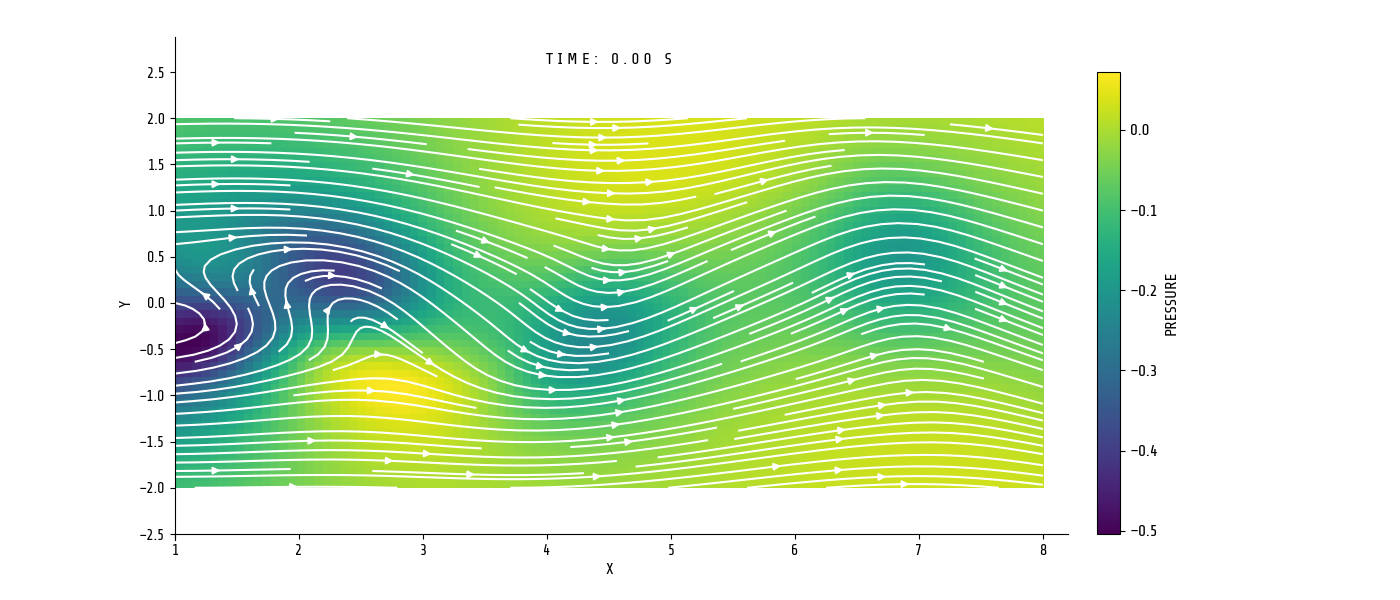

In [17]:
fig, _ = utils.plotting.wake_cylinder(x_star, u_star, p_star, time, figsize=(14, 6))

## Step 2 and 3: Prepare and Pre-process Data
***
The next step is to pre-process the data. This involves normalizing the data and splitting it into training, validation, and test sets.

### Training, Validation, and Test Sets
***
One of the crucial steps in machine learning is to split the data into training, validation, and test sets. Each of these sets serves a specific purpose in the model development process:

| Dataset | Purpose | Typical Split | Usage | Analogy |
|---------|---------|---------------|--------|----------|
| Training Set | Used to train the model by adjusting weights and biases through backpropagation | 60-80% | Every training iteration | Like studying materials to learn a subject |
| Validation Set | Used to tune hyperparameters and monitor model performance during training to prevent overfitting | 10-20% | During model development | Like practice exams to gauge learning progress |
| Test Set | Used only once for final model evaluation; never used for training or tuning | 10-20% | Once, after training | Like a final exam with new, unseen questions |
***
> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Note**: We are going to use only 1% of the total dataset for training (the authors have already prepared the data in this way). This is to highlight the ability of PINNs to learn from limited data. In practice, you would typically use a larger portion of the dataset for training. Thus, we are not going to split the dataset into training, validation, and test sets. Instead, we will use the entire dataset for training and testing. This is a common practice in PINNs, where the model is trained on a small portion of the data and then tested on the entire dataset.

In [5]:
N, T = x_star.shape[0], time.shape[0] # number of points in space and time

# Create coordinate grids 
x_flat = x_star[:, 0]  # Extract x coordinates
y_flat = x_star[:, 1]  # Extract y coordinates
t_flat = time.flatten() # Flatten time array

# Create meshgrid-like structures for visualization
x_coords = np.tile(x_flat[:, np.newaxis], (1, T))  # Repeat x for each timestep
y_coords = np.tile(y_flat[:, np.newaxis], (1, T))  # Repeat y for each timestep
time_coords = np.tile(t_flat, (N, 1))              # Repeat time for each spatial point

# Extract velocity and pressure data
u_vals = u_star[:, 0, :]  # Extract u velocity
v_vals = u_star[:, 1, :]  # Extract v velocity
p_vals = p_star[:, :]     # Extract pressure

# Flatten into NT x 1 arrays
x = x_coords.flatten()[:, np.newaxis]
y = y_coords.flatten()[:, np.newaxis]
t = time_coords.flatten()[:, np.newaxis]
u = u_vals.flatten()[:, np.newaxis]
v = v_vals.flatten()[:, np.newaxis]
p = p_vals.flatten()[:, np.newaxis]

idx = np.random.choice(N*T, N, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

### Normalisation
***
Normalisation is a crucial step in the pre-processing of data for machine learning models. It involves scaling the input features to a similar range, which helps improve the convergence speed and performance of the model. In this notebook, we will use scale the data to the range [-1, 1] using Min-Max scaling. This is a common technique used in machine learning to ensure that all features contribute equally to the model's performance.
Min-Max scaling transforms the data to a fixed range, typically [0, 1] or [-1, 1]. The formula for Min-Max scaling is:
$$
X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}} \cdot (max - min) + min
$$
where:
- $X$ is the original data
- $X_{min}$ and $X_{max}$ are the minimum and maximum values of the feature, respectively
- $min$ and $max$ are the desired minimum and maximum values of the scaled data, respectively

The normalisation parameters will be computed from the training set and then applied to the validation and test sets. This helps to prevent data leakage and ensures that the model is evaluated on unseen data. 

| Benefit | Description | Impact on Training |
|---------|-------------|-------------------|
| **Faster Convergence** | Normalized inputs lead to better-conditioned optimization | Reduces training time |
| **Numerical Stability** | Prevents extremely large or small values | Reduces risk of gradient explosions/vanishing |
| **Feature Scaling** | Makes all features contribute equally to the model | Prevents certain features from dominating |
| **Better Generalization** | Helps models transfer between different images | Improves performance on unseen data |

***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 1**: Normalisation using Min-Max scaling

```python
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training
X_train_scaled = scaler.transform(X_train)

# Inverse transform the scaled data to get the original values
X_train_original = scaler.inverse_transform(X_train_scaled)
```

> <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"> **Important**: For PINNs, the features cannot be normalised in the same way as in traditional machine learning. Standard normalization in PINNs is tricky because physical equations must remain consistent with the scaled variables. The normalization should be applied to the loss function considering the physics of the problem. This is a more complex process and requires a deeper understanding of the physical equations involved. In this workshop, we will not cover this topic in detail, but it is important to keep in mind that normalisation in PINNs is not as straightforward as in traditional machine learning.

In [6]:
# Preparing the data as tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

t_train = torch.tensor(t_train, dtype=torch.float32)
u_train = torch.tensor(u_train, dtype=torch.float32)
v_train = torch.tensor(v_train, dtype=torch.float32)


## Step 4: Activation Function
***
The next step is to choose an activation function for the model. The activation function introduces non-linearity to the model, allowing it to learn complex relationships in the data. The following table lists some common activation functions used in neural networks, along with their characteristics and best use cases:

| Function | Formula | Range | PyTorch Implementation | Best Used For |
|----------|---------|-------|-------------------|---------------|
| ReLU | $f(x) = \max(0, x)$ | $[0, \infty)$ | `torch.nn.ReLU()` | Hidden layers in most networks |
| Sigmoid | $f(x) = \frac{1}{1+e^{-x}}$ | $(0, 1)$ | `torch.nn.Sigmoid()` | Binary classification, gates in LSTMs |
| Tanh | $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | $(-1, 1)$ | `torch.nn.Tanh()` | Hidden layers when output normalization is needed |
| Leaky ReLU | $f(x) = \max(\alpha x, x)$ | $(-\infty, \infty)$ | `torch.nn.LeakyReLU(negative_slope=0.01)` | Preventing "dead neurons" problem |
| Softmax | $f(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$ | $(0, 1)$ | `torch.nn.Softmax(dim=1)` | Multi-class classification output layer |

The choice of activation function depends on the specific problem and the architecture of the neural network. 

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Tips**:
> - ReLU is the most commonly used activation function in hidden layers of deep networks due to its simplicity and effectiveness.
> - The activation function for the output layer depends on the type of problem being solved (e.g., regression, binary classification, multi-class classification).
***
> <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> **Common Mistakes to Avoid**: 
> - Mixing activation functions in the same layer (e.g., using ReLU and sigmoid together) can lead to unexpected behavior.
> - Using activation functions that saturate (like sigmoid) in hidden layers can lead to vanishing gradients, making training difficult.
> - Forgetting to apply the activation function to the output layer can lead to incorrect predictions (e.g., not using softmax for multi-class classification).
> - Not considering the range of the output when choosing the activation function (e.g., using sigmoid for regression tasks).

In [7]:
print("\n🧠 Quiz 1: Choosing the right activation function")
quizzer.run_quiz(1)

print("\n🧠 Quiz 2: Combining activation functions")
quizzer.run_quiz(2)


🧠 Quiz 1: Choosing the right activation function
--------------------------------------------------------------------------------
📋 Activation Functions Quiz
--------------------------------------------------------------------------------
For a regression problem like predicting the robot arm joint angles, which activation function would be most appropriate for the output layer?

A. Sigmoid - to constrain all outputs between 0 and 1

B. ReLU - to ensure no negative values in the output

C. Linear (no activation) - to allow any numeric output value

D. Softmax - to convert outputs into probability distributions

E. Tanh - to constrain all outputs between -1 and 1


❌ Incorrect. The correct answer is C.

📚 Explanation:
For regression problems, where we need to predict continuous values like joint
angles, the linear activation (or no activation) is most appropriate for the
output layer. This is because:  1. Regression outputs need the full range of
possible values, not constrained to int


## Step 5: Model
***
The next step is to define the model architecture. In order to create a Neural Network we need to stack multiple neurons together. This is known as a **layer**. A layer is a collection of neurons that work together to process the input data. A simple ANN is formed by three types of layers:
   - **Input Layer**: Receives the input data.
   - **Hidden Layers**: Intermediate layers that process the data.
   - **Output Layer**: Produces the final output.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\layers.png" alt="ANN layers" align="center" style="width: 20%; height: auto; margin: 0 auto;">
</figure>

The following table summarises the different types of layers available in PyTorch:

| Layer Type | Class | Description | Common Uses |
|------------|-------|-------------|------------|
| Fully Connected | `torch.nn.Linear(in_features, out_features)` | Standard dense layer | Classification, regression |
| Convolutional | `torch.nn.Conv2d(in_channels, out_channels, kernel_size)` | Spatial feature extraction | Image processing |
| Recurrent | `torch.nn.RNN(input_size, hidden_size)` | Sequential data processing | Time series, text |
| LSTM | `torch.nn.LSTM(input_size, hidden_size)` | Long-term dependencies | Complex sequences |
| Embedding | `torch.nn.Embedding(num_embeddings, embedding_dim)` | Word vector representations | NLP tasks |
| BatchNorm | `torch.nn.BatchNorm2d(num_features)` | Normalizes layer inputs | Training stability |
| Dropout | `torch.nn.Dropout(p=0.5)` | Randomly zeros elements | Regularization |

The choice of layer type depends on the specific problem and the architecture of the neural network. For example, convolutional layers are commonly used in image processing tasks, while recurrent layers are used for sequential data processing.

### Number of Layers and Neurons
***
The number of layers and neurons in each layer is a hyperparameter that needs to be tuned. The following table summarises the common practices for choosing the number of layers and neurons:

| Layer Type | Common Practices |
|----------------|------------------|
| Input Layer | Number of neurons = number of input features |
| Hidden Layers | 1-3 hidden layers are common for most tasks. More complex tasks may require more layers. |
| Output Layer | Number of neurons = number of output features (e.g., 1 for regression, number of classes for classification) |
| Number of Neurons | Common practices: 2^n, where n is the number of layers. A common practice is to start with a number of neurons equal to the number of input features and then reduce the number of neurons in each subsequent layer. |
***

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Tips**:
> - Start with a simple architecture and gradually increase complexity as needed.
> - The number of neurons in each layer can be adjusted based on the complexity of the problem.
> - Use activation functions after each layer to introduce non-linearity.
> - Experiment with different layer types and configurations to find the best architecture for your problem.




In [8]:
# Quiz 3: Network Width
print("\n🧠 Quiz 3: Understanding Network Width for Inverse Kinematics")
quizzer.run_quiz(3)

# Quiz 4: Network Depth
print("\n🧠 Quiz 4: Understanding Network Depth for Inverse Kinematics")
quizzer.run_quiz(4)

# Quiz 5: Regularization Techniques
print("\n🧠 Quiz 5: Regularization Techniques for Kinematics Models")
quizzer.run_quiz(5)


🧠 Quiz 3: Understanding Network Width for Inverse Kinematics
--------------------------------------------------------------------------------
📋 Neural Network Width Quiz
--------------------------------------------------------------------------------
For the robot arm inverse kinematics regression problem, which statement about network width (number of neurons in hidden layers) is most accurate?

A. A single neuron in each hidden layer is sufficient since this is a simple regression task

B. The number of neurons should exactly match the number of input features (6)

C. The hidden layers should have more neurons than inputs to capture complex spatial relationships

D. The hidden layers should have fewer neurons than the output to prevent overfitting

E. The width of the network doesn't impact performance, only the depth matters


❌ Incorrect. The correct answer is C.

📚 Explanation:
The hidden layers should have more neurons than inputs to capture complex
spatial relationships in the 

### Initialising Weights and Biases
***

In the previous session we looked at the concept of weights and biases. With our Perceptron we initialised the weights and biases to random values. In PyTorch, we can use different methods to initialise the weights and biases of a neural network.

The importance of initialising weights and biases lies in the fact that they can significantly affect the convergence speed and performance of the neural network. Proper initialisation can help prevent issues such as vanishing or exploding gradients, which can hinder the training process.

| Initialisation Method | Formula | PyTorch Code | Description |
|-----------------------|----------|--------------|-------------|
| Xavier/Glorot Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}})$ | `torch.nn.init.xavier_uniform_(tensor)` | Suitable for sigmoid and tanh activations. |
| He Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Kaiming Normal Initialisation | $W \sim \mathcal{N}(0, \sqrt{\frac{2}{n_{in}}})$ | `torch.nn.init.kaiming_normal_(tensor)` | Suitable for ReLU activations. |
| Kaiming Uniform Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Zero Initialisation | $W = 0$ | `torch.nn.init.zeros_(tensor)` | All weights are set to zero. Not recommended. |
| Random Initialisation | $W \sim \mathcal{U}(-1, 1)$ | `torch.nn.init.uniform_(tensor)` | Weights are randomly initialised between -1 and 1. |
***
> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Tips**:
> - Use Xavier or He initialisation for most cases, as they are designed to maintain the variance of activations across layers.
> - Avoid zero initialisation, as it can lead to symmetry problems where all neurons learn the same features.
> - PyTorch uses Kaiming initialisation by default for `torch.nn.Linear` layers, which is suitable for ReLU activations.
> - Experiment with different initialisation methods to see their impact on training speed and model performance.


# The PINN Model
***
In this workshop we are going to use a Physics-Informed Neural Network (PINN) to solve the Navier-Stokes equations. The PINN model is a neural network that is trained to satisfy the Navier-Stokes equations, as well as the boundary conditions of the problem. The PINN model consists of the following components:

| Component | Description |
|----------|-------------|
| Neural Network | A feedforward neural network that takes the input features (e.g., coordinates, time) and outputs the predicted values (e.g., velocity, pressure). |
| Loss Function | A combination of the mean squared error (MSE) loss and the physics loss, which is based on the Navier-Stokes equations. |
| Optimiser | An optimisation algorithm (e.g., Adam, SGD) that updates the weights and biases of the neural network during training. |
***
<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\pinn.png" alt="PINN model" align="center" style="width: 45%; height: auto; margin: 0 auto;">
</figure>

For the connected layers we are going to use the following activation functions:
| Layer | Activation Function |
|-------|---------------------|
| Input Layer | Tanh |
| Hidden Layers | Tanh |
| Output Layer | Tanh |

The choice of activation function for the output layer is important, as it can affect the range of the output values. In this case, we are using Tanh to ensure that the output values are in the range [-1, 1]. This is important for the PINN model, as we want to ensure that the predicted values are in the same range as the input features.


In [7]:
# Exercise 2: Model Creation with Weight Initialization 🎯
class CylinderPINN(torch.nn.Module):
    def __init__(self, hidden_size=20, num_layers=9):
        super().__init__()
        self.nu = 0.01  # kinematic viscosity
        
        # Neural network architecture
        layers = []
        layers.append(torch.nn.Linear(3, hidden_size))  # Input layer: x, y, t
        layers.append(torch.nn.Tanh())
        
        for _ in range(num_layers - 1):
            layers.append(torch.nn.Linear(hidden_size, hidden_size))
            layers.append(torch.nn.Tanh())
            
        layers.append(torch.nn.Linear(hidden_size, 2))  # Output layer: ψ (stream function), p (pressure)
        
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x, y, t):
        # Combine inputs
        inputs = torch.cat([x, y, t], dim=1)
        # Get stream function (ψ) and pressure (p)
        outputs = self.net(inputs)
        psi, p = outputs[:, 0:1], outputs[:, 1:2]
        
        # Calculate velocities and their derivatives
        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        v = -torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        
        return u, v, p

model = CylinderPINN(hidden_size=20, num_layers=9)

## Step 6: Choose Optimiser
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Optimisers are algorithms used to update the model parameters during training to minimise the loss function.

The next step is to choose an optimiser for the model.



The optimiser algorithm is used to update the model parameters during training. Most optimizers use a version of gradient descent to update the model parameters. The goal of the optimiser is to minimize the loss function by adjusting the weights and biases of the model. The most commonly used optimizers include:

| Optimizer | PyTorch Implementation | Best Used For |
|-----------|---------------------|--------------|
| Stochastic Gradient Descent (SGD) | `torch.optim.SGD(params, lr)` | Simple problems, good with momentum |
| Adam | `torch.optim.Adam(params, lr)` | Most deep learning tasks |
| RMSProp | `torch.optim.RMSprop(params, lr)` | Deep neural networks |
| Adagrad | `torch.optim.Adagrad(params, lr)` | Sparse data tasks |
| AdamW | `torch.optim.AdamW(params, lr)` | When regularization is important |
| LBFGS | `torch.optim.LBFGS(params)` | Small datasets, expensive computations |

The Adam optimiser is a popular choice for training deep learning models due to its efficiency and effectiveness. It combines the benefits of both SGD and RMSProp, making it suitable for a wide range of tasks.

### Learning Rate
***
The learning rate is a hyperparameter that determines the step size at each iteration while moving toward a minimum of the loss function. A small learning rate may lead to slow convergence, while a large learning rate may cause the model to diverge. It is important to choose an appropriate learning rate for the optimizer to work effectively

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\learning_rate.png" alt="Gradient Descent" align="center" style="width: 30%; height: auto; margin: 0 auto;">
</figure>

## PINN Optimiser
***
When training a PINN model, the choice of optimiser is crucial for achieving good performance. While the Adam optimiser is a popular choice for many deep learning tasks, it may not always be the best choice for PINNs. A better choice for PINNs is the L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) optimiser, which is a quasi-Newton method that approximates the inverse Hessian matrix. L-BFGS is particularly well-suited for PINNs because it can efficiently handle the large number of parameters in the model and can converge faster than Adam in some cases.

However, in order to use L-BFGS, we need to ensure that the loss function is differentiable with respect to the model parameters. This is important because L-BFGS uses second-order information (the Hessian) to update the model parameters. If the loss function is not differentiable, L-BFGS may not converge or may converge to a suboptimal solution. 

To use the L-BFGS optimiser in PyTorch, we need to define a closure function that computes the loss and gradients. The closure function is called by the L-BFGS optimiser to compute the loss and gradients at each iteration. The closure function should return the loss value and the gradients of the model parameters with respect to the loss.
***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 2**: Using L-BFGS Optimiser

```python
import torch.optim as optim

# Define the model
model = PINNModel()
# Define the loss function
loss_function = PINNLoss()
# Define the optimizer
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Define the closure function
def closure():
    optimizer.zero_grad()
    loss = loss_function(model)
    loss.backward()
    return loss

# Training loop
for epoch in range(num_epochs):
    optimizer.step(closure)
```




## Step 7: Choose Loss Function
***
The next step is to choose a loss function for the model. The choice of loss function depends on the type of problem being solved. The loss function measures how well the model is performing and guides the optimisation process. The most commonly used loss functions include:

| Loss Function | PyTorch Implementation | Best Used For |
|---------------|---------------------|--------------|
| Mean Squared Error (MSE) | `torch.nn.MSELoss()` | Regression tasks |
| Mean Absolute Error (MAE) | `torch.nn.L1Loss()` | Regression tasks |
| Binary Cross-Entropy | `torch.nn.BCELoss()` | Binary classification tasks |
| Categorical Cross-Entropy | `torch.nn.CrossEntropyLoss()` | Multi-class classification tasks |
| Hinge Loss | `torch.nn.HingeEmbeddingLoss()` | Support Vector Machines (SVM) |
| Kullback-Leibler Divergence | `torch.nn.KLDivLoss()` | Probabilistic models |

The loss works in conjunction with the optimiser. While there are loss functions that can work for the same task, the choice of loss will have an effect on the final performance of the model. For instance, using MSE (L2-Norm) loss for a regression task will penalise larger errors more than smaller ones, while MAE (L1-Norm) loss treats all errors equally. This can lead to different model performance depending on the distribution of the data.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\losses.png" alt="Loss Functions" align="center" style="width: 30%; height: auto; margin: 0 auto;">
</figure>

***

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Tips**:
> - Choose a loss function that is appropriate for the type of problem being solved (e.g., regression, classification).
> - Monitor the loss during training to ensure that the model is converging and not overfitting.
> - Experiment with different loss functions to see their impact on model performance.

## PINN Loss Function
***
The loss function for the PINN model is a combination of the mean squared error (MSE) loss and the physics loss, which is based on the Navier-Stokes equations. The total loss function can be expressed as:
$$
L_{total} = L_{MSE} + \lambda_1 L_{convective} + \lambda_2 L_{viscous} + \lambda_3 L_{pressure}
$$
where:
- $L_{MSE}$ is the mean squared error loss between the predicted and true values
- $L_{convective}$ is the loss associated with the convective term of the Navier-Stokes equations
- $L_{viscous}$ is the loss associated with the viscous term of the Navier-Stokes equations
- $L_{pressure}$ is the loss associated with the pressure term of the Navier-Stokes equations
- $\lambda_1$, $\lambda_2$, and $\lambda_3$ are the weights for each term in the loss function. These weights can be adjusted to balance the contributions of each term to the total loss. The choice of these weights is important, as they can significantly affect the performance of the PINN model.

We can calculate the residuals of the Navier-Stokes equations using the following equations:
$$
\begin{align*}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \\
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} &= 0
\end{align*}
$$
where:
- $u$ and $v$ are the x and y components of the velocity field, respectively
- $p$ is the pressure field
- $\rho$ is the density of the fluid
- $\nu$ is the kinematic viscosity of the fluid
- $t$ is the time
- $x$ and $y$ are the spatial coordinates




In [10]:
# Exercise 4: Optimizer and Loss Function Selection 🎯
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def compute_pde_loss(model, x, y, t):
    u, v, p = model(x, y, t)
    
    # Calculate all required derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    
    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    
    # Navier-Stokes equations residuals
    f = u_t + u * u_x + v * u_y + p_x - model.nu * (u_xx + u_yy)
    g = v_t + u * v_x + v * v_y + p_y - model.nu * (v_xx + v_yy)
    
    return f, g

## Step 8 and 9: Create Training Loop and Fit Model
***
The training loop implements the key steps for training a neural network model:

| Step | Description | Code Example |
|------|-------------|--------------|
| 1. Forward Pass | Pass input data through model to generate predictions | `predictions = model(inputs)` |  
| 2. Loss Computation | Calculate loss between predictions and targets | `loss = criterion(predictions, targets)` |
| 3. Backward Pass | Compute gradients through backpropagation | `loss.backward()` |
| 4. Parameter Updates | Update model parameters using optimizer | `optimizer.step()` |
| 5. Gradient Reset | Zero out gradients for next iteration | `optimizer.zero_grad()` |

The next step is to fit the model using the training data. The model is trained for a specified number of epochs, and the training and validation loss is monitored during training. The number of epochs is a hyperparameter that determines how many times the model will be trained on the entire training dataset.

***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 3**: Training Loop Structure

```python
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    # 1. Forward Pass
    predictions = model(inputs)
    
    # 2. Loss Computation
    loss = criterion(predictions, targets)
    
    # 3. Backward Pass
    loss.backward()
    
    # 4. Parameter Updates
    optimizer.step()
    
    # 5. Gradient Reset
    optimizer.zero_grad()



Training on: cuda


Training PINN: 100%|██████████| 10000/10000 [27:56<00:00,  5.96it/s, data_loss=0.0238, physics_loss=0.0056, total_loss=0.0293]


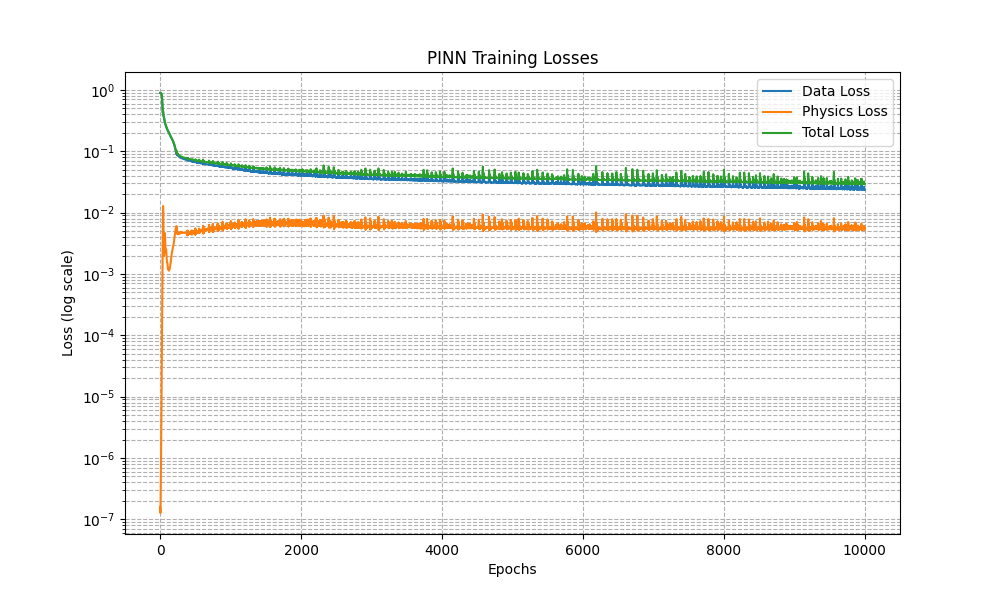

In [23]:
def train_pinn(model, data, epochs=20000, lr=0.001):
    x, y, t, u_true, v_true = data
    
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on: {device}")
    
    # Move model to device
    model = model.to(device)
    
    # Check if inputs are already tensors, if not convert them
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32)
    if not isinstance(t, torch.Tensor):
        t = torch.tensor(t, dtype=torch.float32)
    if not isinstance(u_true, torch.Tensor):
        u_true = torch.tensor(u_true, dtype=torch.float32)
    if not isinstance(v_true, torch.Tensor):
        v_true = torch.tensor(v_true, dtype=torch.float32)
        
    # Move tensors to device
    x = x.to(device)
    y = y.to(device)
    t = t.to(device)
    u_true = u_true.to(device)
    v_true = v_true.to(device)
    
    # Set requires_grad=True for inputs to compute gradients
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = torch.nn.MSELoss()
    
    # Use tqdm for the progress bar
    pbar = tqdm(range(epochs), desc="Training PINN")
    
    # Lists to store losses for plotting
    data_losses = []
    physics_losses = []
    total_losses = []
    
    for epoch in pbar:
        optimizer.zero_grad()
        
        # Data loss
        u_pred, v_pred, _ = model(x, y, t)
        data_loss = mse_loss(u_pred, u_true) + mse_loss(v_pred, v_true)
        
        # Physics loss
        f, g = compute_pde_loss(model, x, y, t)
        physics_loss = mse_loss(f, torch.zeros_like(f)) + mse_loss(g, torch.zeros_like(g))
        
        # Total loss
        total_loss = data_loss + physics_loss
        
        # Store losses
        data_losses.append(data_loss.item())
        physics_losses.append(physics_loss.item())
        total_losses.append(total_loss.item())
        
        total_loss.backward()
        optimizer.step()
        
        # Update the progress bar with current losses
        pbar.set_postfix({
            'data_loss': f'{data_loss.item():.4f}',
            'physics_loss': f'{physics_loss.item():.4f}',
            'total_loss': f'{total_loss.item():.4f}'
        })
        
    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.semilogy(data_losses, label='Data Loss')
    plt.semilogy(physics_losses, label='Physics Loss')
    plt.semilogy(total_losses, label='Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('PINN Training Losses')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
    
    return model

# Train the model
model = CylinderPINN(hidden_size=20, num_layers=9)
trained_model = train_pinn(model, (x_train, y_train, t_train, u_train, v_train), epochs=10000, lr=0.001)


In [24]:
# save the model
torch.save(trained_model.state_dict(), 'cylinder_pinn_model.pth')


### Overfitting, Underfitting, and Early Stopping
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Overfitting occurs when a model learns the training data too well, including noise and outliers, leading to poor generalisation on unseen data. Underfitting occurs when a model is too simple to capture the underlying patterns in the data.

As we can see in the following figure, the training loss decreases over time, while the validation loss follows a similar trend. However, the validation loss starts to slowly deviate from the training loss after a certain number of epochs. This indicates that the model is starting to overfit the training data. The point at which the validation loss starts to increase is known as the "early stopping" point. This is the point at which we should stop training the model to prevent overfitting.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\over_under_fit.png" alt="Overfitting" align="center" style="width: 60%; height: auto; margin: 0 auto;">

## Step 10: Evaluate Model
***
The next step is to evaluate the model using the validation and test data. The model is evaluated on the validation set during training to monitor its performance and prevent overfitting. 

Since we are training a model with MSE loss, we can also plot the predicted output against the actual output to see how well the model is performing. The predicted output should be close to the actual output, and the points should be clustered around the diagonal line. If the points are scattered far from the diagonal line, it indicates that the model is not performing well.

We can also compute the R-squared value to quantify the performance of the model. The R-squared value is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The R-squared value ranges from 0 to 1, where 0 indicates that the model does not explain any of the variance in the data, and 1 indicates that the model explains all of the variance in the data.

For this step we are going to use the test set to evaluate the model. 

***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 3**: Evaluate Model

```python
# Set model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass through the model
    predictions = model(inputs)

    # Compute loss
    loss = criterion(predictions, targets)
```

interactive(children=(IntSlider(value=0, description='Time Step', max=199), Output()), _dom_classes=('widget-i…

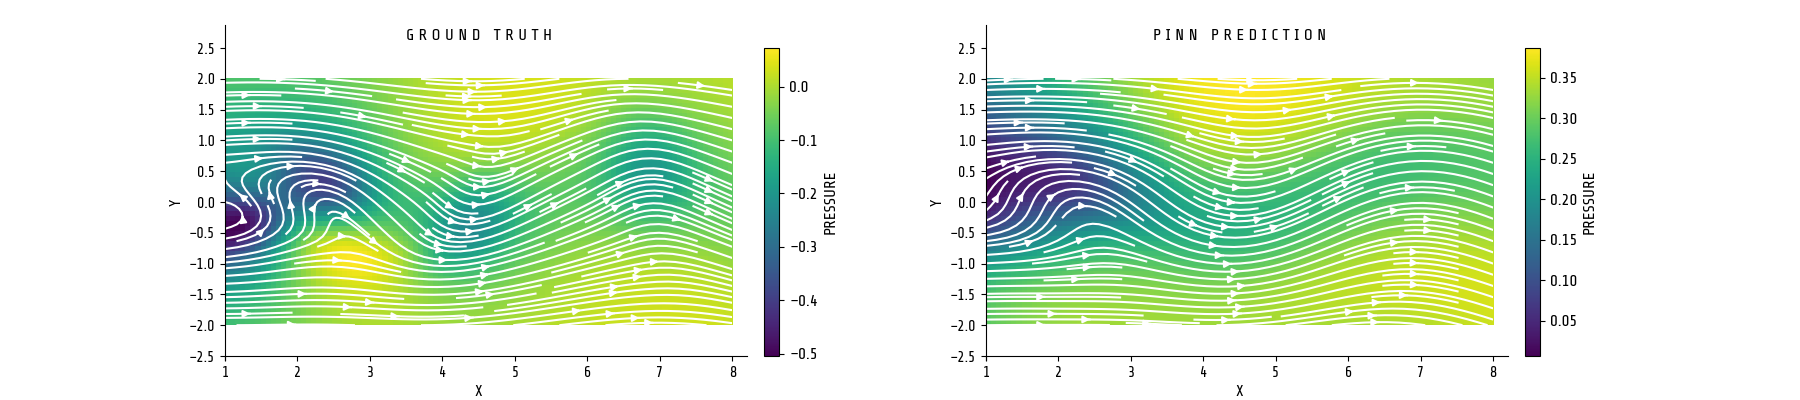

In [14]:
# Get predictions from model
import utils.plotting

# Load the model
model = CylinderPINN(hidden_size=20, num_layers=9)
model.load_state_dict(torch.load('cylinder_pinn_model.pth'))

model.eval()
model.to('cpu')
with torch.no_grad():
    u_pred = []
    v_pred = []
    p_pred = []
    
    for t_idx in range(time.shape[0]):
        # Create input tensors with requires_grad=True
        x_tensor = torch.FloatTensor(x_star[:,0]).view(-1, 1).requires_grad_(True)
        y_tensor = torch.FloatTensor(x_star[:,1]).view(-1, 1).requires_grad_(True)
        t_tensor = torch.full_like(x_tensor, time[t_idx,0]).requires_grad_(True)
        
        # Get predictions - temporarily enable gradients
        with torch.enable_grad():
            u_t, v_t, p_t = model(x_tensor, y_tensor, t_tensor)
        
        # Store predictions
        u_pred.append(u_t.detach().cpu().numpy())
        v_pred.append(v_t.detach().cpu().numpy())
        p_pred.append(p_t.detach().cpu().numpy())
    
    # Convert to arrays and reshape
    u_pred = np.stack(u_pred, axis=1)  # Shape: (N, T)
    v_pred = np.stack(v_pred, axis=1)  # Shape: (N, T)
    p_pred = np.stack(p_pred, axis=1)  # Shape: (N, T)

# Reshape ground truth data
u_true = u_star[:, 0, :]  # Shape: (N, T)
v_true = u_star[:, 1, :]  # Shape: (N, T)
p_true = p_star  # Shape: (N, T)

# Create visualization
fig, (ax1, ax2) = utils.plotting.visualize_flow_comparison(
    x_star, u_true, v_true, p_true,
    u_pred, v_pred, p_pred, time,
    figsize=(18, 4), 
)